# MNIST Autoencoder Example

Note: This notebook is desinged to run with Python3 and CPU (no GPU) runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_cpu.png)

This notebook uses TensorFlow2.x.

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


####[MAE-01]
Import modules.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

####[MAE-02]
Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

11490434/11490434 [==============================] - 0s 0us/step


####[MAE-03]
Define an autoencoder model for MNIST images.

In [4]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(28*28,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(784, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 128)               2176      
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
Total params: 472608 (1.80 MB)
Trainable params: 472608 

####[MAE-04]
Compile the model using the Adam optimizer, and MSE as a loss function.

In [5]:
model.compile(optimizer='adam', loss='mse')

####[MAE-05]
Define a function to show reconstructed images.

In [6]:
def show_result():
    results = model.predict(test_images[:8], verbose=0)

    fig = plt.figure(figsize=(16, 2.7))
    for i in range(8):
      subplot = fig.add_subplot(2, 10, i+1)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(test_images[i].reshape((28, 28)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)

      subplot = fig.add_subplot(2, 10, i+11)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(results[i].reshape((28, 28)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)

####[MAE-06]
Train the model for a single epoch with 30,000 images, and show the intermediate result.

118/118 [==============================] - 5s 6ms/step - loss: 0.0739


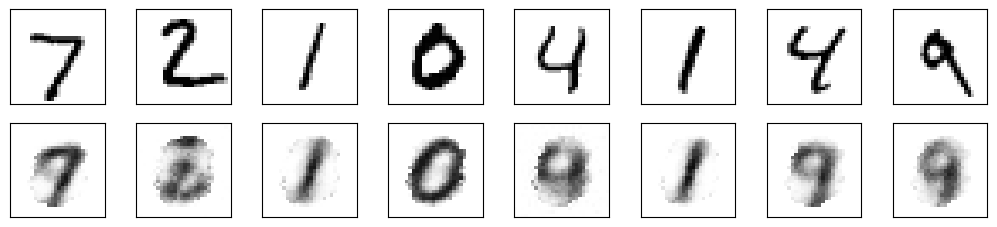

In [7]:
history = model.fit(train_images[:30000], train_images[:30000],
                    batch_size=256, epochs=1)
show_result()

####[MAE-07]
Train the model for additional epochs, and show the final result.

Epoch 1/6
235/235 [==============================] - 1s 6ms/step - loss: 0.0330
Epoch 2/6
235/235 [==============================] - 1s 6ms/step - loss: 0.0234
Epoch 3/6
235/235 [==============================] - 1s 6ms/step - loss: 0.0203
Epoch 4/6
235/235 [==============================] - 1s 4ms/step - loss: 0.0187
Epoch 5/6
235/235 [==============================] - 1s 4ms/step - loss: 0.0177
Epoch 6/6
235/235 [==============================] - 1s 4ms/step - loss: 0.0169


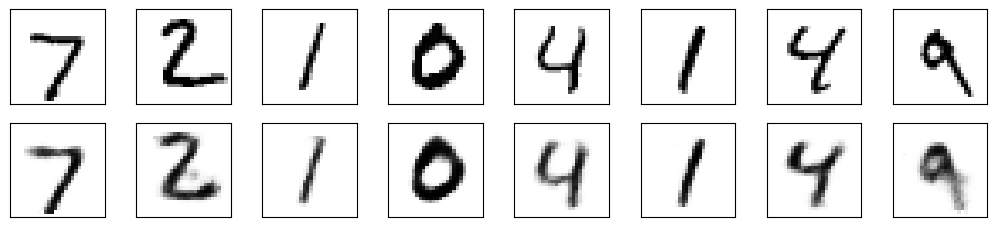

In [8]:
history = model.fit(train_images, train_images,
                    batch_size=256, epochs=6)
show_result()

####[MAE-08]
Define a Javascript function to create a drawing canvas.

In [9]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e) {
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0, 0, 0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY*0.2);
            y = Math.floor(e.offsetX*0.2) + 1;
            for (var dy = 0; dy < 2; dy++) {
                for (var dx = 0; dx < 2; dx++) {
                    if ((x + dx < 28) && (y + dy < 28)) {
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });

    function set_value() {
        var result = "";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        google.colab.kernel.invokeFunction(
                          'notebook.set_image', [result], {});
    }

    function clear_value() {
        canvas.getContext("2d").fillStyle = "rgb(255, 255, 255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
"""

####[MAE-09]
Show a drawing canvas.

In [10]:
from google.colab import output
from IPython.display import HTML

def set_image(result):
    global image
    image = np.array([float(x) for x in result.split(',')[:-1]])

image = None
output.register_callback('notebook.set_image', set_image)

HTML(input_form + javascript)

####[MAE-10]
Show a resconstructed image from the handwritten example.

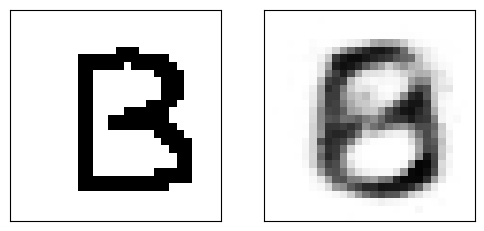

In [13]:
results = model.predict(np.array([image]), verbose=0)

fig = plt.figure(figsize=(6, 3))
subplot = fig.add_subplot(1, 2, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(np.array(image).reshape((28, 28)),
               vmin=0, vmax=1, cmap=plt.cm.gray_r)
subplot = fig.add_subplot(1, 2, 2)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(results[0].reshape((28, 28)),
               vmin=0, vmax=1, cmap=plt.cm.gray_r)